In [82]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

# Data loading

In [6]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load mtor, we want to remember source of data and Standard and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("VDR_IC50.csv") as inp:
    vdr = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in vdr:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "vdr"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [7]:
vdr

[{'Molecule ChEMBL ID': 'CHEMBL385265',
  'Molecule Name': '',
  'Molecule Max Phase': '0',
  'Molecular Weight': '540.79',
  '#RO5 Violations': '2',
  'AlogP': '6.30',
  'Compound Key': '81b',
  'Smiles': 'C=C1/C(=C\\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H](C)C[C@@H]2OC(=O)C(=C)[C@H]2CC(C)C)C[C@@H](O)[C@H](CCCO)[C@@H]1O',
  'Standard Type': 'IC50',
  'Standard Relation': "'='",
  'Standard Value': 9.3,
  'Standard Units': 'nM',
  'pChEMBL Value': 8.03,
  'Data Validity Comment': '',
  'Comment': '',
  'Uo Units': 'UO_0000065',
  'Ligand Efficiency BEI': '',
  'Ligand Efficiency LE': '',
  'Ligand Efficiency LLE': '',
  'Ligand Efficiency SEI': '',
  'Potential Duplicate': 'False',
  'Assay ChEMBL ID': 'CHEMBL910037',
  'Assay Description': 'Antagonist activity against 1-alpha,25-dihydroxy vitamin D3-induced HL60 cell differentiation by NBT reduction method',
  'Assay Type': 'F',
  'BAO Format ID': 'BAO_0000219',
  'BAO Label': 'cell-based format',
  'Assay Organism': 'Homo sapiens',
  'A

In [8]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("cdd2021/data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })


In [9]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in vdr if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4e40>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4990>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f17518a8a30>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a40d0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4120>,<rdkit.Chem.rdchem.Mol object at 0x7f175169bd50>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,15,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f175169bc60>,<rdkit.Chem.rdchem.Mol object at 0x7f175169b530>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f175169b210>,<rdkit.Chem.rdchem.Mol object at 0x7f175169e440>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,12,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f17516a47b0>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4b20>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4bc0>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4f30>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f175169f030>,<rdkit.Chem.rdchem.Mol object at 0x7f175169f3a0>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1
6788,6788,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f175169f440>,<rdkit.Chem.rdchem.Mol object at 0x7f175169f7b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",295.80,6.53,5,...,0,0,1,1,0,0,0,0,0,0


In [10]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

In [11]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4e40>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4990>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",610002.00,0.00,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f17518a8a30>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a40d0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",610002.00,0.00,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4120>,<rdkit.Chem.rdchem.Mol object at 0x7f175169bd50>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",610002.00,0.00,15,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f175169bc60>,<rdkit.Chem.rdchem.Mol object at 0x7f175169b530>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",610002.00,0.00,16,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f175169b210>,<rdkit.Chem.rdchem.Mol object at 0x7f175169e440>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",610002.00,0.00,12,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f17516a47b0>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4b20>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4bc0>,<rdkit.Chem.rdchem.Mol object at 0x7f17516a4f30>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f175169f030>,<rdkit.Chem.rdchem.Mol object at 0x7f175169f3a0>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1
6788,6788,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f175169f440>,<rdkit.Chem.rdchem.Mol object at 0x7f175169f7b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",295.80,6.53,5,...,0,0,1,1,0,0,0,0,0,0


In [17]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error vdr: {(res[res["Source"]=="vdr"]["Prediction"]-res[res["Source"]=="vdr"][predicted_value]).abs().mean()}""")
    return res

# Radnom Forest

In [13]:
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [18]:
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 510070.4975917243
Average error vdr: 72192.5447580618


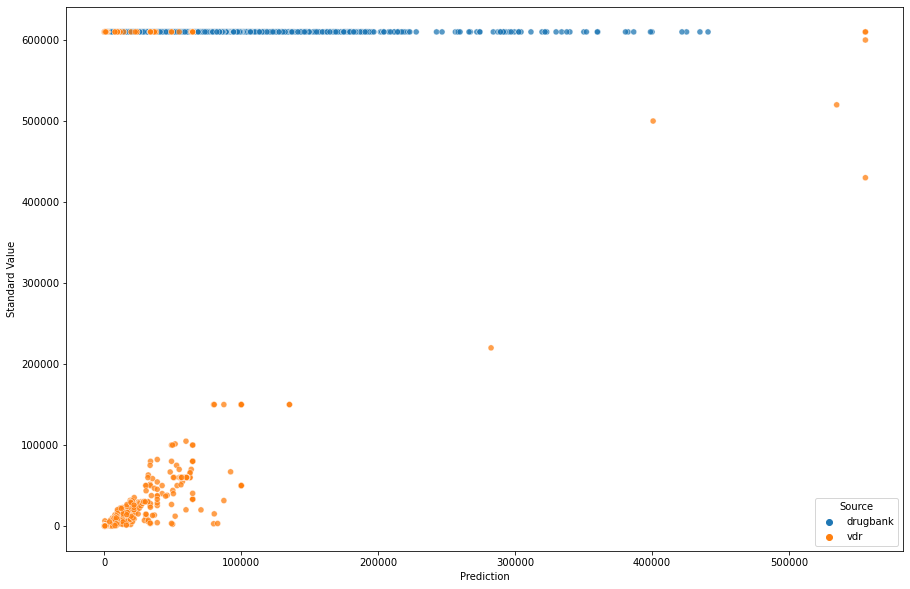

In [19]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

<ipython-input-20-b813a0770aac>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],


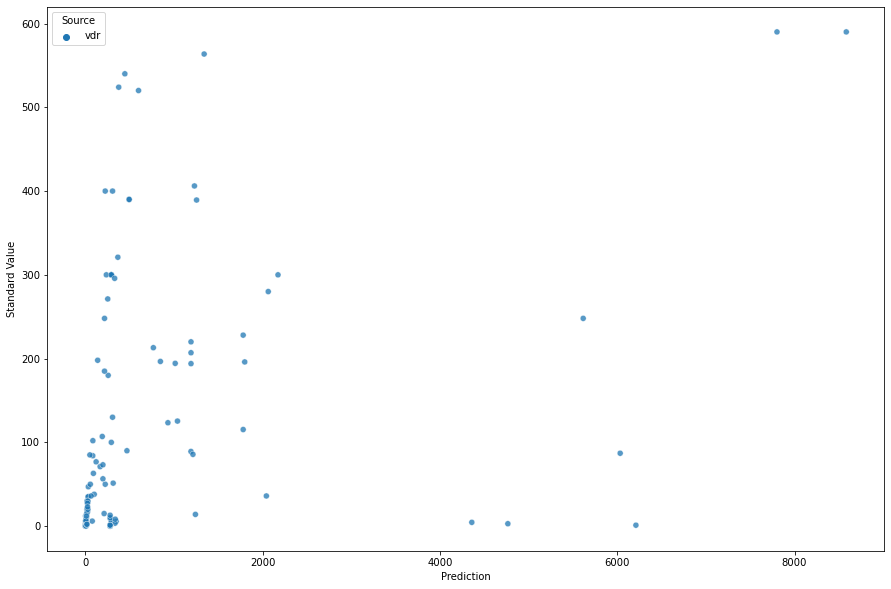

In [20]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [21]:
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [22]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [23]:
len(trainset), len(testset)

(317, 106)

In [24]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [25]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.22156917957095182
Average error vdr: 0.22156917957095182


In [26]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.4506392660103399
Average error vdr: 0.4506392660103399


In [27]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.84
R: 0.92
MSE: 0.48


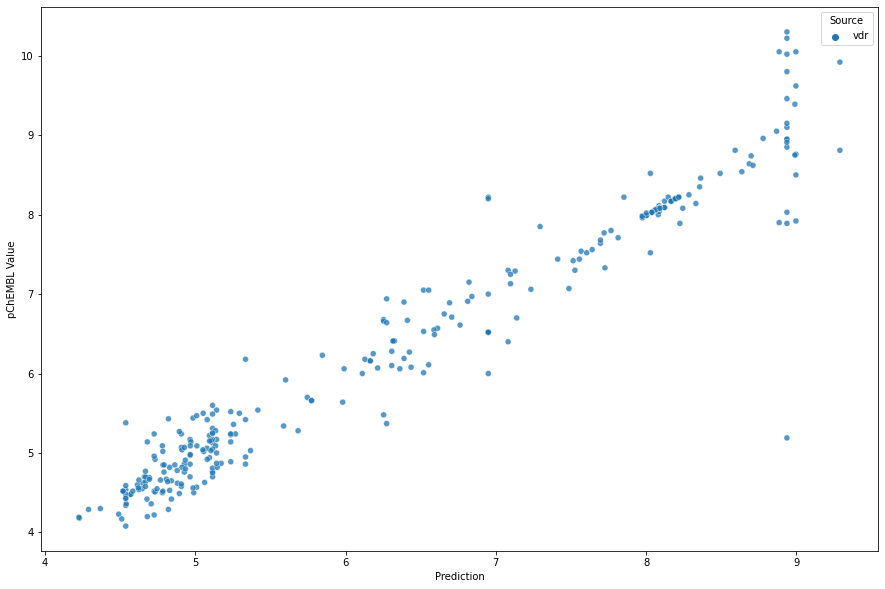

In [28]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

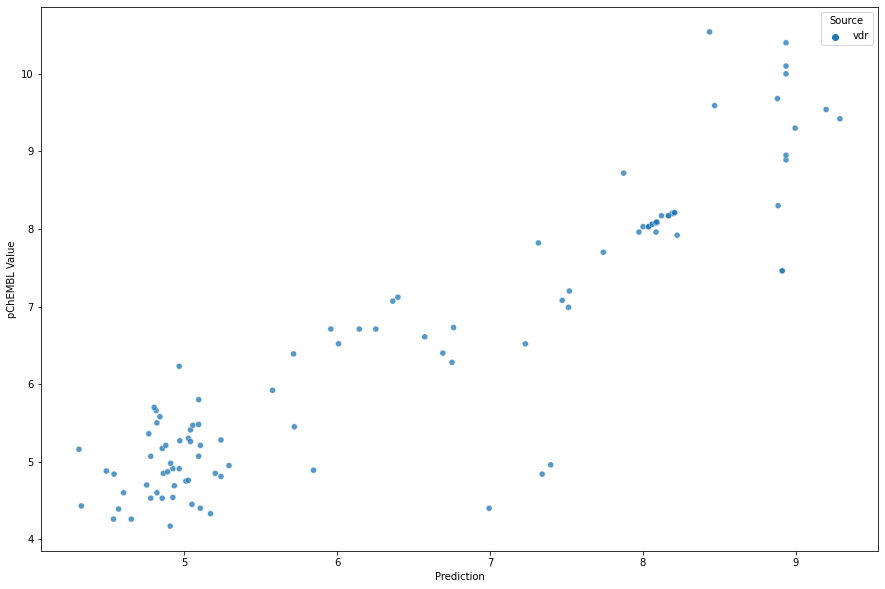

In [29]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Proto ze mam ligandu u kterych mam nenulovou pCHembl value jenom 423 tak 
pro predikci pouziju Standard Value a prevedeme smiles na  morganuv fingerprint

Pouzijeme Morganuv Fingerprints

In [30]:
df["Molecule"] = [Chem.MolFromSmiles(mol) for mol in df["std_smiles"]] 
df['bin'] = [np.array(Chem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in df['Molecule']]

Budeme predikovat standard value

In [31]:
data = df[['index', 'bin', 'Standard Value']]
data

,index,bin,Standard Value
0,0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",610002.00
1,1,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",610002.00
2,2,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",610002.00
3,3,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",610002.00
4,4,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",610002.00
...,...,...,...
6785,6785,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00
6786,6786,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00
6787,6787,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13
6788,6788,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",295.80


In [32]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [34]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [42]:
X = train.bin.tolist()
y = train['Standard Value'].tolist()

x_pred = test.bin.tolist()
y_real = test['Standard Value'].tolist()

In [41]:
rfr = RandomForestRegressor(n_estimators=101, max_features=32, max_depth=4, random_state=0)
rfr.fit(X, y)


RandomForestRegressor(max_depth=4, max_features=32, n_estimators=101,
                      random_state=0)

In [43]:
y_pred = rfr.predict(x_pred)

In [44]:
y_pred

array([593384.59607457, 583626.06974943, 584385.67428746, ...,
       595839.5046614 , 583575.75236005, 593103.41424802])

In [48]:
print("MSE: %0.2f" %  mean_squared_error(y_pred, y_real))

MSE: 12112699903.32


No uplne ten model nepredikuje dobre :]

Zkusim predikovan pChembl i kdyz tech hodnot neni moct, myslim si ze to bude 
mit lepsi predikci

In [50]:
data = df[['index', 'bin', 'pChEMBL Value']]
data

,index,bin,pChEMBL Value
0,0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
1,1,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
2,2,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.00
3,3,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
4,4,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.00
...,...,...,...
6785,6785,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",5.54
6786,6786,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.18
6787,6787,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.95
6788,6788,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",6.53


In [52]:
data = data[data['pChEMBL Value']> 0]

In [53]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [54]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [56]:
X = train.bin.tolist()
y = train['pChEMBL Value'].tolist()

x_pred = test.bin.tolist()
y_real = test['pChEMBL Value'].tolist()

In [57]:
rfr = RandomForestRegressor(n_estimators=101, max_features=32, max_depth=4, random_state=0)
rfr.fit(X, y)


RandomForestRegressor(max_depth=4, max_features=32, n_estimators=101,
                      random_state=0)

In [58]:
y_pred = rfr.predict(x_pred)

In [59]:
y_pred

array([5.11170203, 7.86662352, 5.06043269, 5.21417521, 8.02873133,
       6.07390834, 8.17063878, 6.32007508, 8.00502871, 7.33963345,
       5.18182804, 4.92256196, 8.01465645, 6.14793162, 7.85759624,
       5.0181641 , 5.09994273, 8.31288456, 4.90879132, 7.93030215,
       6.1345695 , 8.03082289, 6.121746  , 7.33963345, 4.92118661,
       4.99770621, 4.93280618, 8.00502871, 6.66659534, 8.00751074,
       8.31288456, 5.03726484, 7.99508542, 5.06043269, 4.98710977,
       5.00515096, 7.89011651, 4.93991585, 5.0020413 , 6.1345695 ,
       6.92919162, 4.96314156, 4.94746065, 8.31288456, 7.69739712,
       4.92118661, 5.02784739, 5.07821705, 8.0517041 , 6.26306815,
       5.05667448, 8.01492109, 7.99508542, 8.09325867, 4.93308307,
       4.90879132, 8.02890837, 6.12722284, 8.01465645, 4.90628015,
       8.00851564, 5.01821606, 7.96241792, 4.92106042, 8.01695745,
       6.9712707 , 7.99181753, 8.00851564, 7.83472985, 5.20289341,
       5.00055016, 4.93280618, 5.08886909, 4.93308307, 6.66659

In [79]:
print("MSE: %0.2f" %  mean_squared_error( y_real,y_pred))
print("Regressor score:", rfr.score(x_pred, y_real))

MSE: 0.32
Regressor score: 0.8833855401996078


Uz ten model je lepsi]

In [66]:
test['Prediction'] = y_pred

In [67]:
test

,index,bin,pChEMBL Value,Prediction
0,6385,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",4.96,5.111702
1,6181,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.46,7.866624
2,6785,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",5.54,5.060433
3,6163,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4.40,5.214175
4,6299,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.21,8.028731
...,...,...,...,...
80,6734,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",9.92,8.095776
81,6157,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.85,4.918968
82,6526,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.11,7.991818
83,6507,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",5.80,5.089487


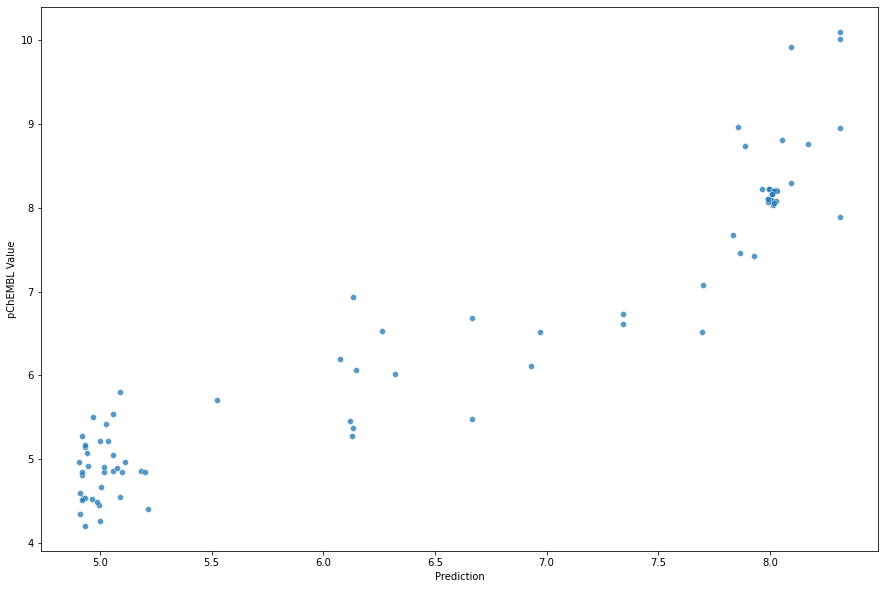

In [70]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test,
                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Zkusime upravit trosku hyper parametry a treba to jeste nejak zlepsi predikci

In [106]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(data['bin'],data['pChEMBL Value'] ,test_size=0.2, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridRan = {
    "n_estimators": range(1,100,5),
    "max_depth": range(1,10)
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains].tolist()
    train_y = y_train.iloc[trains].tolist()
    valid_x = X_train.iloc[valids].tolist()
    valid_y = y_train.iloc[valids].tolist()
    
    
    param_comb = ParameterGrid(param_gridRan)
    for params in param_comb:
        rfc = RandomForestRegressor(**params)
        rfc = rfc.fit(train_x,train_y)
        pre_rfc = rfc.predict(valid_x)

        mse1=  mean_squared_error(valid_y, rfc.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimalni_parametr pro Random Forest", opt_param)   

Valid MSE 0.16137441950044334
Optimalni_parametr pro Random Forest {'max_depth': 9, 'n_estimators': 21}


Ted natrenujeme nas model s optimalnimi daty

In [108]:


train, test = train_test_split(data, test_size=0.2, random_state=0)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

X = train.bin.tolist()
y = train['pChEMBL Value'].tolist()

x_pred = test.bin.tolist()
y_real = test['pChEMBL Value'].tolist()

rfr = RandomForestRegressor(**opt_param)
rfr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, rfc.predict(x_pred)))
print("Regressor score:", rfr.score(x_pred, y_real))

Test MSE
MSE: 0.24
Regressor score: 0.9179677271318438


In [109]:
test['Prediction'] = y_pred

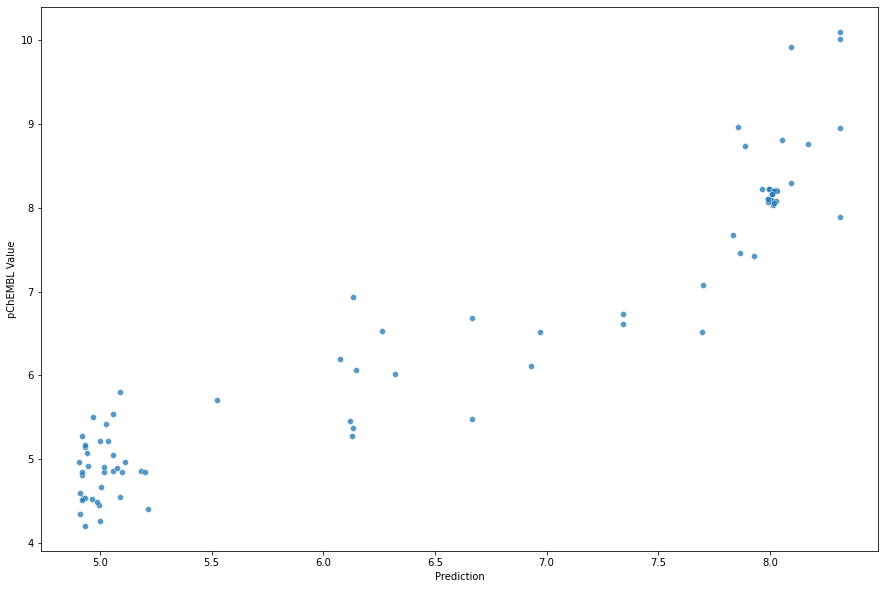

In [110]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test,
                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )